# Titanic: Machine Learning from Disaster

This notebook summarizes my efforts for working on the [Kaggle Titanic challenge](https://www.kaggle.com/c/titanic). The final ensemble method achieved a prediction accuracy of 0.79425 for the test set.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from collections import Counter

from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier

import warnings
warnings.filterwarnings('ignore')

## 1. Data import and wrangling

First, I will import training and test data and have a first look.

In [2]:
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')
test_ids = test['PassengerId']

## Join train and test datasets in order to obtain the same number of features during data transformation
train_len = len(train)
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)
dataset = dataset.fillna(np.nan)

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


### Imputing missing values

In [6]:
dataset.isnull().sum()

Age             263
Cabin          1014
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

While the missing values for the *Survived* attribute stems from the test data set, there are other missing values that have to be dealt with. I decided to fill the missing values as follows:

* *Age:* median within similar rows regarding the most correlated features with Age (Sex, Parch , Pclass and SibSp). If such a row does not exist, I will take the median from the corresponding passenger class.
* *Fare:* median within the corresponding passenger class
* *Embarked:* the only missing value will be replaced by the most frequent value
* *Cabin:* I will replace missing values by 'X'

In [7]:
dataset.Age = dataset.groupby(['Sex','Pclass','Parch','SibSp']).Age.transform(lambda x: x.fillna(x.median()))
dataset.Age = dataset.groupby('Pclass').Age.transform(lambda x: x.fillna(x.median()))
dataset.Fare = dataset.groupby('Pclass').Fare.transform(lambda x: x.fillna(x.median()))
dataset.Embarked = dataset.Embarked.fillna(dataset.Embarked.value_counts().idxmax())
dataset.Cabin = dataset.Cabin.fillna('X')

In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
Age            1309 non-null float64
Cabin          1309 non-null object
Embarked       1309 non-null object
Fare           1309 non-null float64
Name           1309 non-null object
Parch          1309 non-null int64
PassengerId    1309 non-null int64
Pclass         1309 non-null int64
Sex            1309 non-null object
SibSp          1309 non-null int64
Survived       891 non-null float64
Ticket         1309 non-null object
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


## 2. Feature engineering

Now, I will look at the available data in more detail to identify significant features and decide to create new ones.

### Age

Let's look at the age of survivors versus the age of non-survivors.

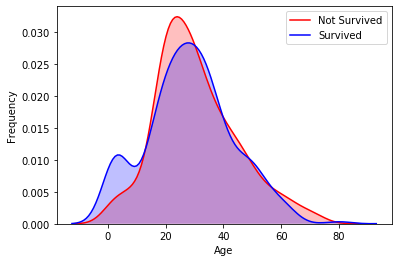

In [9]:
g = sns.kdeplot(train['Age'][(train['Survived'] == 0) & (train['Age'].notnull())], color='Red', shade = True)
g = sns.kdeplot(train['Age'][(train['Survived'] == 1) & (train['Age'].notnull())], ax =g, color='Blue', shade= True)
g.set_xlabel('Age')
g.set_ylabel('Frequency')
g = g.legend(['Not Survived','Survived'])

Clearly, the distributions are different. In particular, it appears that minors were more likely to survive compared to adults of 18 years or more. I therefore decided to create additional features from the age column.

In [10]:
dataset['minor'] = (dataset.Age < 18).astype(int)
dataset['adult'] = (dataset.Age >= 18).astype(int)

### Sex

In [11]:
train[['Sex', 'Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.742038
male,0.188908


Clearly, women were more likely to survive. But to use this feature efficiently, the data has to be transformed.

In [12]:
dataset['Sex'] = dataset['Sex'].map({'male': 0, 'female':1})

### Passenger class

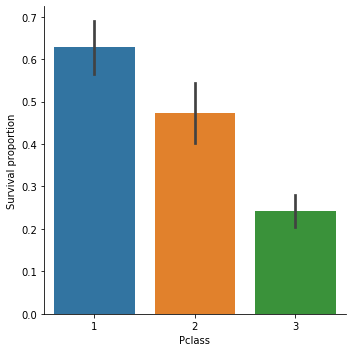

In [13]:
g = sns.factorplot(x='Pclass', y='Survived', data=train, kind='bar')
g = g.set_ylabels('Survival proportion')

Just like sex, the passenger class apears to have a significant influence on survival. To use the feature efficiently, I will convert the column to cummy variables.

In [14]:
dataset['Pclass'] = dataset['Pclass'].astype('category')
dataset = pd.get_dummies(dataset, columns = ['Pclass'], prefix='PC')

### Family size

The dataset contains the two columns *SibSp* (# of siblings / spouses aboard the Titanic) and *Parch* (# of parents / children aboard the Titanic).

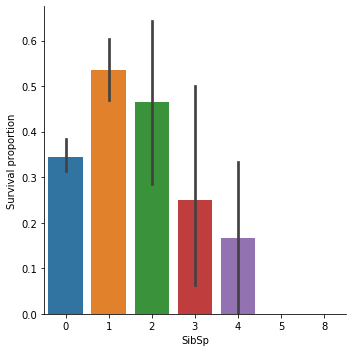

In [15]:
g = sns.factorplot(x='SibSp', y='Survived', data=train, kind='bar')
g = g.set_ylabels('Survival proportion')

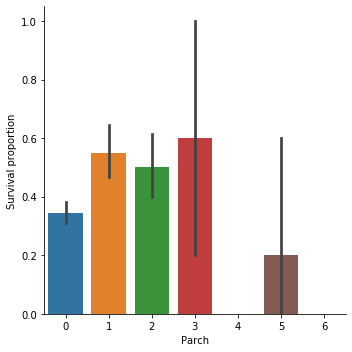

In [16]:
g = sns.factorplot(x='Parch', y='Survived', data=train, kind='bar')
g = g.set_ylabels('Survival proportion')

I decided to combine these two into a new feature *fam_size*:

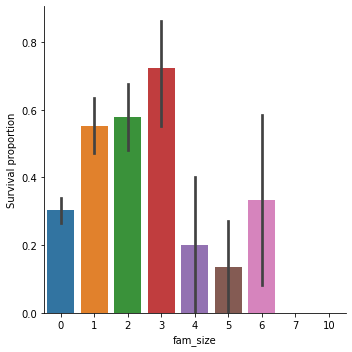

In [17]:
dataset['fam_size'] = dataset['Parch'] + dataset['SibSp']

g = sns.factorplot(x='fam_size', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels('Survival proportion')

Now, there appears to be a clear trend that medium size families (2-4 members) have a higher probability to survive compared to singles and large families (> 4 members). Therefore, I decided to create additional features for these:

In [18]:
dataset['single'] = (dataset['fam_size'] == 0).astype(int)
dataset['med_fam_size'] = ((dataset['fam_size'] > 0) & (dataset['fam_size'] <= 3)).astype(int)
dataset['large_fam_size'] = (dataset['fam_size'] > 3).astype(int)

### Fare

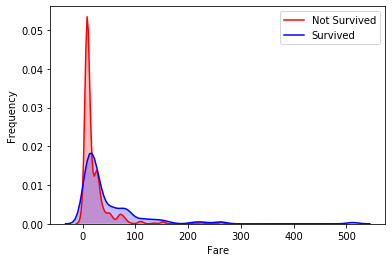

In [19]:
g = sns.kdeplot(train['Fare'][(train['Survived'] == 0) & (train['Fare'].notnull())], color='Red', shade = True)
g = sns.kdeplot(train['Fare'][(train['Survived'] == 1) & (train['Fare'].notnull())], ax =g, color='Blue', shade= True)
g.set_xlabel('Fare')
g.set_ylabel('Frequency')
g = g.legend(['Not Survived','Survived'])

As can be seen above, Fare is correlated with survival. However, using Fare as a feature as is poses a problem due to its skewed distribution (see below), which can lead to overweigth when fitting a model.

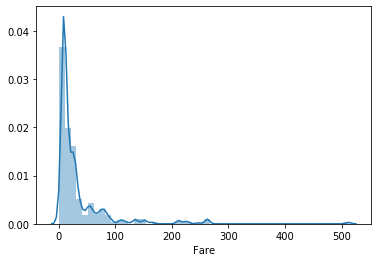

In [20]:
g = sns.distplot(dataset['Fare'])

For this reason, I decided to (1) add a new booean feature *high_fare* and additionally transform the original Fare feature using a logarithmic transformation:

In [21]:
high_fare_cutoff = 50
dataset['high_fare'] = dataset.Fare <= high_fare_cutoff
dataset.groupby('high_fare').Survived.mean()

high_fare
False    0.681250
True     0.318741
Name: Survived, dtype: float64

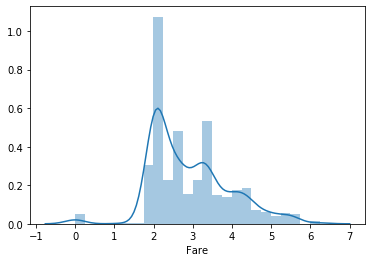

In [22]:
dataset['Fare'] = dataset['Fare'].apply(lambda x: np.log(x) if x > 0 else 0)
g = sns.distplot(dataset['Fare'])

### Titles

Despite the fact that names are commonly useless for feature engineering, I noticed that the names in this dataset have a standardized structure that allows to extract the title of each person:

In [23]:
dataset['title'] = dataset.Name.str.split(',').str[1].str.split().str[0]
dataset.title.value_counts()

Mr.          757
Miss.        260
Mrs.         197
Master.       61
Dr.            8
Rev.           8
Col.           4
Ms.            2
Mlle.          2
Major.         2
Capt.          1
Lady.          1
Jonkheer.      1
Dona.          1
Sir.           1
Don.           1
Mme.           1
the            1
Name: title, dtype: int64

This still includes several female titles that I will combine and a lot of rare titles that I will also combine into a *Rare* category.

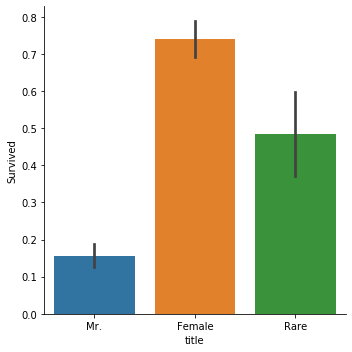

In [24]:
dataset['title'] = dataset['title'].replace(['Miss.', 'Mrs.', 'Ms.', 'Mlle.', 'Mme.', 'Lady.'], 'Female')
dataset['title'] = dataset['title'].replace(['Master.', 'Dr.', 'Rev.', 'Col.', 'Major.', 'the', 'Dona.', 
                                             'Jonkheer.', 'Don.', 'Capt.', 'Sir.'], 'Rare')
g = sns.factorplot(x='title', y='Survived', data=dataset, kind='bar')

In [25]:
dataset['title'] = dataset['title'].astype('category')
dataset = pd.get_dummies(dataset, columns = ['title'], prefix='title')

### Embarked

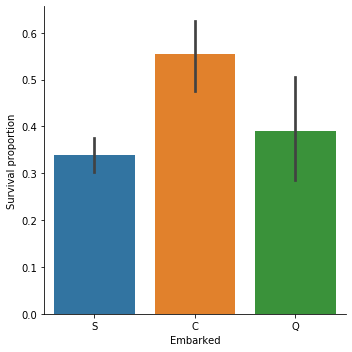

In [26]:
g = sns.factorplot(x='Embarked', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels('Survival proportion')

It appears that the port where passengers embarked is correlated with their survival. I Therefore, I am also adding dummy variables to use this information for predictions.

In [27]:
dataset['Embarked'] = dataset['Embarked'].astype('category')
dataset = pd.get_dummies(dataset, columns = ['Embarked'], prefix='Emb')

### Cabin

I decided to retain only the deck information, where *X* indicates missing cabin information.

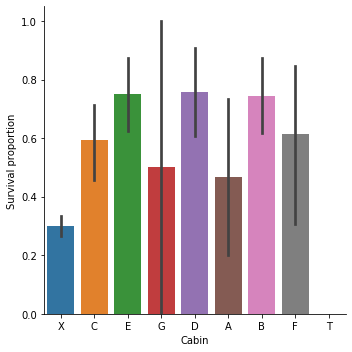

In [28]:
dataset['Cabin'] = dataset.Cabin.str[0]
g = sns.factorplot(x='Cabin', y='Survived', data=dataset, kind='bar')
g = g.set_ylabels('Survival proportion')

The deck also seems to be somehow linked to survival, so I will add dummy variables.

In [29]:
dataset['Cabin'] = dataset['Cabin'].astype('category')
dataset = pd.get_dummies(dataset, columns = ['Cabin'], prefix='Cab')

### Final cleaning and preparing

At last, I will remove all non-needed columns: 

In [30]:
dataset.drop(labels = ['PassengerId', 'Name', 'Ticket'], axis = 1, inplace = True)
dataset.columns

Index(['Age', 'Fare', 'Parch', 'Sex', 'SibSp', 'Survived', 'minor', 'adult',
       'PC_1', 'PC_2', 'PC_3', 'fam_size', 'single', 'med_fam_size',
       'large_fam_size', 'high_fare', 'title_Female', 'title_Mr.',
       'title_Rare', 'Emb_C', 'Emb_Q', 'Emb_S', 'Cab_A', 'Cab_B', 'Cab_C',
       'Cab_D', 'Cab_E', 'Cab_F', 'Cab_G', 'Cab_T', 'Cab_X'],
      dtype='object')

Furthermore, I am scaling the numerical (non-dummy) features using a MinMaxScaler, which will cause all features to be in the range [0, 1] afterwards.

In [31]:
numerical_features = ['Age', 'Fare', 'Parch', 'SibSp', 'fam_size']
for nm in numerical_features:
    dataset[nm] = MinMaxScaler().fit_transform(dataset[[nm]])

## 3. Feature Selection

With feature engineering being done, it is time to select the features used for Survival prediction. After splitting features and labels, I first apply a variance filter to remove features below a certain variance threshold.

In [32]:
# Separate features and (training) labels
X = dataset.copy().drop(labels = ["Survived"], axis=1)
Y_train = dataset[:train_len].Survived

# Applying a variance filter
var_threshold = 0.1
selector = VarianceThreshold(threshold=var_threshold).fit(X)
X = X.loc[:, selector.get_support()]
print('Remaining features after applying variance threshold %s:' % var_threshold, list(X.columns))

Remaining features after applying variance threshold 0.1: ['Sex', 'minor', 'adult', 'PC_1', 'PC_2', 'PC_3', 'single', 'med_fam_size', 'high_fare', 'title_Female', 'title_Mr.', 'Emb_C', 'Emb_S', 'Cab_X']


Next, I am considering the results of a chi2-test and an ANOVA F-test to determine the expressiveness of the remaining features. 

In [33]:
# computer chi2 and ANOVA test results
chi2_results = chi2(X[:train_len], Y_train)
anova_results = f_classif(X[:train_len], Y_train)

# summarize results in a DataFrame
df = pd.DataFrame({'feature': X.columns, 'chi2': chi2_results[0], 'chi2_p_val': chi2_results[1],
                   'anova_F': anova_results[0], 'anova_p_val': anova_results[1]})
df.sort_values('chi2', ascending=False)

,feature,chi2,chi2_p_val,anova_F,anova_p_val
0,Sex,170.348127,6.210585e-39,372.405724,1.406066e-69
9,title_Female,167.703935,2.347846e-38,362.485350,4.745974e-68
10,title_Mr.,112.805785,2.379805e-26,383.945495,2.428783e-71
3,PC_1,55.175151,1.102538e-13,79.136403,3.190582e-18
7,med_fam_size,46.912822,7.421558e-12,75.541509,1.702390e-17
5,PC_3,41.553071,1.147141e-10,103.057599,5.510281e-23
13,Cab_X,20.488314,5.999642e-06,99.253142,3.090891e-22
11,Emb_C,20.464401,6.075071e-06,25.895987,4.397151e-07
6,single,14.640793,1.300685e-04,38.353651,9.009490e-10
8,high_fare,13.097711,2.956568e-04,79.262652,3.008766e-18


Taking the results of both tests into account, I am deciding to drop adult, Emb_S and PC_2.

Finally, I will have a look at feature correlations, to ensure that all remaining features are sufficiently different from each other.

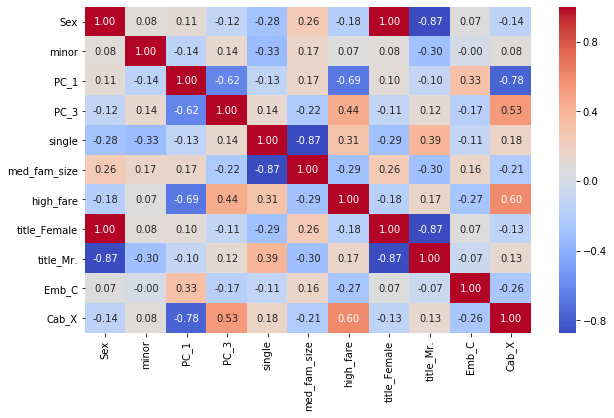

In [34]:
X.drop(labels = ['adult', 'Emb_S', 'PC_2'], axis=1, inplace=True)
fig, ax = plt.subplots(figsize=(10,6))
g = sns.heatmap(X.corr(), annot=True, fmt = ".2f", cmap = "coolwarm", ax=ax)

As can be seen, *title_Female* correspondands exactly to *Sex*. Fair enough, this is not very surprising, and I will drop *title_Female* as a result.

In [35]:
X.drop(labels = ['title_Female'], axis=1, inplace=True)

## Separate the features dataset into train set and test set
X_train = X[:train_len]
X_test = X[train_len:]
print('Selected features:', list(X_train.columns))

Selected features: ['Sex', 'minor', 'PC_1', 'PC_3', 'single', 'med_fam_size', 'high_fare', 'title_Mr.', 'Emb_C', 'Cab_X']


## 4. Modelling

I decided to try the following popular classifiers and evaluate the mean accuracy of each of them using a stratified kfold cross validation procedure.

* Logistic regression
* Naive Bayes
* k-Nearest Neighbors
* Decision Tree
* Support Vector Machine
* Random Forest
* Extra Trees
* AdaBoost 
* Gradient Boosting

In [36]:
kfold = StratifiedKFold(n_splits=5)
random_state = 42

classifiers = []
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(GaussianNB())
classifiers.append(KNeighborsClassifier())
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),
                                      random_state=random_state, learning_rate=0.1))
classifiers.append(GradientBoostingClassifier(random_state=random_state))

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y=Y_train, scoring="accuracy", cv=kfold, n_jobs=2))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

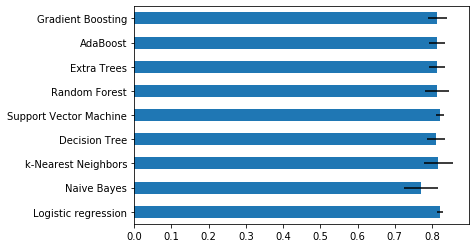

In [37]:
names = ['Logistic regression', 'Naive Bayes', 'k-Nearest Neighbors', 'Decision Tree', 'Support Vector Machine', 
         'Random Forest', 'Extra Trees', 'AdaBoost', 'Gradient Boosting']
    
cv_res = pd.DataFrame({'name': names, 'mean': cv_means, 'std': cv_std})
cv_res.plot(kind='barh', x='name', y='mean', xerr='std', legend=False)
plt.ylabel('')
plt.show()

Not too bad! I decided to further assess Support Vector Machine, Logistic Regression, Random Forest, AdaBoost and Gradient Boosting via grid search to optimize their parameters. Eventually, I will also use all of them for an ensemble classifier. 

In [38]:
def save_prediction(model, prefix, testset=X_test):
    pred = pd.Series(model.predict(testset), name="Survived").astype(int)
    results = pd.concat([test_ids, pred],axis=1)
    results.to_csv(prefix + '_submission.csv', index=False)
    
def myGridSearch(model, params):
    gs = GridSearchCV(model, param_grid=params, cv=kfold, scoring="accuracy", n_jobs= 2, verbose = 1)
    gs.fit(X_train, Y_train)
    best_model = gs.best_estimator_
    score = gs.best_score_
    print('Best accuracy score:', score)
    
    return (best_model, score)

### Support Vector Machine

In [39]:
svc_param_grid = {'kernel': ['rbf'], 'gamma': np.logspace(-3, 0, 20), 'C': np.logspace(0, 3, 20)}

svc = SVC(probability=True)
svc_best, svc_score = myGridSearch(svc, svc_param_grid)
save_prediction(svc_best, 'svc')

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  88 tasks      | elapsed:    3.5s
[Parallel(n_jobs=2)]: Done 388 tasks      | elapsed:   15.8s
[Parallel(n_jobs=2)]: Done 888 tasks      | elapsed:   38.4s
[Parallel(n_jobs=2)]: Done 1588 tasks      | elapsed:  1.3min


Best accuracy score: 0.8305274971941639


[Parallel(n_jobs=2)]: Done 2000 out of 2000 | elapsed:  2.0min finished


### Logistic Regression

In [40]:
lg_param_grid = {'C': np.logspace(-3, 3, 20), 'penalty': ['l1', 'l2', 'elasticnet'],
                 'class_weight': [None, 'balanced']}

lg = LogisticRegression(solver='saga', l1_ratio=0.5)
lg_best, lg_score = myGridSearch(lg, lg_param_grid)
save_prediction(lg_best, 'lg')

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best accuracy score: 0.8249158249158249


[Parallel(n_jobs=2)]: Done 600 out of 600 | elapsed:    4.0s finished


### Random Forest

In [41]:
rf_param_grid = {'max_depth': [3, 4, 6, 8], 'max_features': [3, 5], 'min_samples_split': [2, 3, 5], 
                 'min_samples_leaf': [1, 2, 3, 5], 'bootstrap': [True, False], 'n_estimators': [100], 
                 'max_features': [0.5, 0.8, None], 'criterion': ['gini']}

rf = RandomForestClassifier()
rf_best, rf_score = myGridSearch(rf, rf_param_grid)
save_prediction(rf_best, 'rf')

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 288 candidates, totalling 1440 fits


[Parallel(n_jobs=2)]: Done  88 tasks      | elapsed:    5.2s
[Parallel(n_jobs=2)]: Done 388 tasks      | elapsed:   23.4s
[Parallel(n_jobs=2)]: Done 888 tasks      | elapsed:   55.0s


Best accuracy score: 0.8305274971941639


[Parallel(n_jobs=2)]: Done 1440 out of 1440 | elapsed:  1.6min finished


### AdaBoost

In [42]:
ab_param_grid = {'base_estimator__criterion': ['gini', 'entropy'], 'base_estimator__splitter': ['best', 'random'],
                 'algorithm': ['SAMME','SAMME.R'], 'n_estimators': [25, 50, 100], 
                 'learning_rate': np.logspace(-3, 1, 10)}

dtc = DecisionTreeClassifier()
ab = AdaBoostClassifier(dtc)
ab_best, ab_score = myGridSearch(ab, ab_param_grid)
save_prediction(ab_best, 'ab')

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  88 tasks      | elapsed:    7.0s
[Parallel(n_jobs=2)]: Done 388 tasks      | elapsed:   39.9s
[Parallel(n_jobs=2)]: Done 888 tasks      | elapsed:  1.4min


Best accuracy score: 0.8159371492704826


[Parallel(n_jobs=2)]: Done 1200 out of 1200 | elapsed:  1.9min finished


### Gradient Boosting

In [43]:
gb_param_grid = {'loss' : ['deviance'], 'n_estimators' : [100], 'learning_rate': [0.05, 0.1, 0.2, 0.3], 
                 'max_depth': [3, 4, 6, 8], 'min_samples_leaf': [1, 2], 'min_samples_split': [2, 3], 
                 'max_features': [0.5, 0.8, None], 'subsample': [0.8, 0.9, 1]}

gb = GradientBoostingClassifier(random_state = random_state)
gb_best, gb_score = myGridSearch(gb, gb_param_grid)
save_prediction(gb_best, 'gb')

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 576 candidates, totalling 2880 fits


[Parallel(n_jobs=2)]: Done  88 tasks      | elapsed:    6.2s
[Parallel(n_jobs=2)]: Done 388 tasks      | elapsed:   43.2s
[Parallel(n_jobs=2)]: Done 663 tasks      | elapsed:  1.8min
[Parallel(n_jobs=2)]: Done 1013 tasks      | elapsed:  2.5min
[Parallel(n_jobs=2)]: Done 1463 tasks      | elapsed:  4.0min
[Parallel(n_jobs=2)]: Done 2013 tasks      | elapsed:  5.4min
[Parallel(n_jobs=2)]: Done 2663 tasks      | elapsed:  7.2min


Best accuracy score: 0.819304152637486


[Parallel(n_jobs=2)]: Done 2880 out of 2880 | elapsed:  8.1min finished


### Ensemble classifier

At last, I am combining the predictions to an ensemble prediction using a voting classifier.

In [44]:
from sklearn.ensemble import VotingClassifier

models = [('svc', svc_best), ('lg', lg_best), ('rfc', rf_best), ('abc', ab_best), ('gbc', gb_best)]
voting_model = VotingClassifier(estimators=models, voting='soft')
voting_model.fit(X_train, Y_train)
voting_predictions = voting_model.predict(X_train)
save_prediction(voting_model, 'ensemble')
accuracy_score(voting_predictions, Y_train)

0.8383838383838383

## 5. New Generation of Gradient Boosting

Inspired by several data science articles, I decided to return to the Titanic dataset to experiment with some popular and newer algorithms often considered the *new generation of gradient boosting*:

* [XGBoost](https://xgboost.readthedocs.io/en/latest/python/python_api.html)
* [Catboost](https://catboost.ai/)
* [LightGBM](https://lightgbm.readthedocs.io/en/latest/)

In [45]:
#import packages
import xgboost as xgb
import lightgbm as lgb
import catboost as cat

### XGBoost

XGBoost has an API similar to the one from sklearn and the data wrangling doen so far will probably fit the needs of XGBoost as well. As a first step, I will determine a good learning rate and number of estimators by fitting a model with early stopping for different learning rates and with temporarily fixed tree-based parameters.

In [46]:
for rounds in [10, 100]:
    print('Early stopping value (rounds without improvement):', rounds)
    learning_rate_results = []
    for learning_rate in [0.01, 0.03, 0.05, 0.1, 0.15, 0.2]:
        xgb1 = xgb.XGBClassifier(learning_rate=learning_rate, n_estimators=10000, max_depth=5, min_child_weight=1, gamma=0, 
                             subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic', nthread=4, 
                             scale_pos_weight=1, seed=42)

        xgb1.fit(X_train, Y_train, eval_metric='auc', early_stopping_rounds=rounds, eval_set=[(X_train, Y_train)], verbose=0)

        #Predict training set:
        xgb_predictions = xgb1.predict(X_train)
        xgb_predprob = xgb1.predict_proba(X_train)[:,1]

        learning_rate_results.append((learning_rate, xgb1.best_iteration, accuracy_score(Y_train, xgb_predictions), 
                        roc_auc_score(Y_train, xgb_predprob)))

    #Final report:
    for res in learning_rate_results:
        print("Learning rate {}: Best iteration: {}, Accuracy: {:.4f}, AUC Score: {:.4f}".format(*res))

Early stopping value (rounds without improvement): 10
Learning rate 0.01: Best iteration: 25, Accuracy: 0.8373, AUC Score: 0.8873
Learning rate 0.03: Best iteration: 27, Accuracy: 0.8406, AUC Score: 0.8882
Learning rate 0.05: Best iteration: 199, Accuracy: 0.8451, AUC Score: 0.9018
Learning rate 0.1: Best iteration: 164, Accuracy: 0.8462, AUC Score: 0.9042
Learning rate 0.15: Best iteration: 127, Accuracy: 0.8462, AUC Score: 0.9058
Learning rate 0.2: Best iteration: 80, Accuracy: 0.8451, AUC Score: 0.9040
Early stopping value (rounds without improvement): 100
Learning rate 0.01: Best iteration: 2387, Accuracy: 0.8462, AUC Score: 0.9058
Learning rate 0.03: Best iteration: 1091, Accuracy: 0.8462, AUC Score: 0.9065
Learning rate 0.05: Best iteration: 1400, Accuracy: 0.8474, AUC Score: 0.9086
Learning rate 0.1: Best iteration: 1400, Accuracy: 0.8462, AUC Score: 0.9096
Learning rate 0.15: Best iteration: 428, Accuracy: 0.8474, AUC Score: 0.9085
Learning rate 0.2: Best iteration: 853, Accura

It seems like the learning rates below 0.05 converge too quickly with early stopping threashold 10, while the other learning rates achieve results comparable to those with early stopping after 100 rounds.

As a tradeoff, I will use a learning rate of 0.15 and 200 estimators in the following.

Now, I will fine-tune other parameters.

In [47]:
param_test_1 = {'max_depth': [3, 5, 7, 9], 'min_child_weight': [1, 3, 5, 7, 9]}

xgb_clf = xgb.XGBClassifier(learning_rate=0.15, n_estimators=200, max_depth=5, min_child_weight=1, 
                        gamma=0, subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic', 
                        nthread=4, scale_pos_weight=1, seed=42)
gsearch1 = GridSearchCV(estimator=xgb_clf, param_grid=param_test_1, scoring='roc_auc', cv=5, n_jobs= 2, verbose=1)
gsearch1.fit(X_train, Y_train)
print('Best parameters:', gsearch1.best_params_)
print('Best score:', gsearch1.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    7.6s


Best parameters: {'max_depth': 5, 'min_child_weight': 9}
Best score: 0.8785510502353077


[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:   15.5s finished


In [48]:
param_test_1b = {'max_depth': [4, 5, 6], 'min_child_weight': [8, 9, 10, 11, 12]}

xgb_clf = xgb.XGBClassifier(learning_rate=0.15, n_estimators=200, max_depth=5, min_child_weight=1, 
                        gamma=0, subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic', 
                        nthread=4, scale_pos_weight=1, seed=42)
gsearch1 = GridSearchCV(estimator=xgb_clf, param_grid=param_test_1b, scoring='roc_auc', cv=5, n_jobs= 2, verbose=1)
gsearch1.fit(X_train, Y_train)
print('Best parameters:', gsearch1.best_params_)
print('Best score:', gsearch1.best_score_)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 15 candidates, totalling 75 fits


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    5.7s


Best parameters: {'max_depth': 5, 'min_child_weight': 10}
Best score: 0.8808402075138694


[Parallel(n_jobs=2)]: Done  75 out of  75 | elapsed:    9.1s finished


Due to these results, I will use max_depth=5 and min_child_weight=10 in the following.

In [49]:
param_test_2 = {'gamma': [0.01 * i for i in range(10)]}

xgb_clf = xgb.XGBClassifier(learning_rate=0.15, n_estimators=200, max_depth=5, min_child_weight=10, 
                        gamma=0, subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic', 
                        nthread=4, scale_pos_weight=1, seed=42)
gsearch1 = GridSearchCV(estimator=xgb_clf, param_grid=param_test_2, scoring='roc_auc', cv=5, n_jobs= 2, verbose=1)
gsearch1.fit(X_train, Y_train)
print('Best parameters:', gsearch1.best_params_)
print('Best score:', gsearch1.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    5.4s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    6.1s finished


Best parameters: {'gamma': 0.0}
Best score: 0.8808402075138694


In [50]:
param_test_2b = {'gamma': [0.001 * i for i in range(10)]}

xgb_clf = xgb.XGBClassifier(learning_rate=0.15, n_estimators=200, max_depth=5, min_child_weight=10, 
                        gamma=0, subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic', 
                        nthread=4, scale_pos_weight=1, seed=42)
gsearch1 = GridSearchCV(estimator=xgb_clf, param_grid=param_test_2b, scoring='roc_auc', cv=5, n_jobs= 2, verbose=1)
gsearch1.fit(X_train, Y_train)
print('Best parameters:', gsearch1.best_params_)
print('Best score:', gsearch1.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    5.1s


Best parameters: {'gamma': 0.007}
Best score: 0.8808942370570346


[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    5.5s finished


Therefore, I am using gamme=0.007 in the following.

In [51]:
param_test_3 = {'subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}

xgb_clf = xgb.XGBClassifier(learning_rate=0.15, n_estimators=200, max_depth=5, min_child_weight=10, 
                        gamma=0.007, subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic', 
                        nthread=4, scale_pos_weight=1, seed=42)
gsearch1 = GridSearchCV(estimator=xgb_clf, param_grid=param_test_3, scoring='roc_auc', cv=5, n_jobs= 2, verbose=1)
gsearch1.fit(X_train, Y_train)
print('Best parameters:', gsearch1.best_params_)
print('Best score:', gsearch1.best_score_)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    4.3s
[Parallel(n_jobs=2)]: Done 180 out of 180 | elapsed:   19.2s finished


Best parameters: {'colsample_bytree': 0.8, 'subsample': 0.8}
Best score: 0.8808942370570346


In [52]:
param_test_3b = {'subsample': [0.75 + i*0.01 for i in range(10)], 'colsample_bytree': [0.75 + i*0.01 for i in range(10)]}

xgb_clf = xgb.XGBClassifier(learning_rate=0.15, n_estimators=200, max_depth=5, min_child_weight=10, 
                        gamma=0.007, subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic', 
                        nthread=4, scale_pos_weight=1, seed=42)
gsearch1 = GridSearchCV(estimator=xgb_clf, param_grid=param_test_3b, scoring='roc_auc', cv=5, n_jobs= 2, verbose=1)
gsearch1.fit(X_train, Y_train)
print('Best parameters:', gsearch1.best_params_)
print('Best score:', gsearch1.best_score_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    7.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   33.8s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:  1.1min


Best parameters: {'colsample_bytree': 0.8, 'subsample': 0.8}
Best score: 0.8808942370570346


[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:  1.2min finished


Obviously, I will stick to subsample=0.8 and colsample_bytree=0.8. At last, I will have a look at the regularization parameters reg_alpha and reg_lambda.

In [53]:
param_test_4 = {'reg_alpha': [0, 1e-6, 1e-4, 0.001, 0.01, 0.1, 1], 'reg_lambda': [0, 1e-6, 1e-4, 0.001, 0.01, 0.1, 1]}

xgb_clf = xgb.XGBClassifier(learning_rate=0.15, n_estimators=200, max_depth=5, min_child_weight=10, 
                        gamma=0.007, subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic', 
                        nthread=4, scale_pos_weight=1, seed=42)
gsearch1 = GridSearchCV(estimator=xgb_clf, param_grid=param_test_4, scoring='roc_auc', cv=5, n_jobs= 2, verbose=1)
gsearch1.fit(X_train, Y_train)
print('Best parameters:', gsearch1.best_params_)
print('Best score:', gsearch1.best_score_)

Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    5.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   29.7s
[Parallel(n_jobs=2)]: Done 245 out of 245 | elapsed:   35.3s finished


Best parameters: {'reg_alpha': 0.1, 'reg_lambda': 1}
Best score: 0.8810242095742457


In [54]:
param_test_4b = {'reg_alpha': np.logspace(-2, 0, 9), 'reg_lambda': np.logspace(-1, 1, 9)}

xgb_clf = xgb.XGBClassifier(learning_rate=0.15, n_estimators=200, max_depth=5, min_child_weight=10, 
                        gamma=0.007, subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic', 
                        nthread=4, scale_pos_weight=1, seed=42)
gsearch1 = GridSearchCV(estimator=xgb_clf, param_grid=param_test_4b, scoring='roc_auc', cv=5, n_jobs= 2, verbose=1)
gsearch1.fit(X_train, Y_train)
print('Best parameters:', gsearch1.best_params_)
print('Best score:', gsearch1.best_score_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    5.7s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   24.7s


Best parameters: {'reg_alpha': 0.1, 'reg_lambda': 1.0}
Best score: 0.8810242095742457


[Parallel(n_jobs=2)]: Done 405 out of 405 | elapsed:   51.3s finished


Hence, I will use reg_alpha=0.1 and reg_lambda=1.0 for the final model. Time for making predictions!

In [55]:
xgb_clf = xgb.XGBClassifier(learning_rate=0.15, n_estimators=200, max_depth=5, min_child_weight=10, 
                        gamma=0.007, subsample=0.8, colsample_bytree=0.8, objective= 'binary:logistic', 
                        reg_alpha=0.1, reg_lambda=1.0, nthread=4, scale_pos_weight=1, seed=42)
xgb_clf.fit(X_train, Y_train, eval_metric='auc', early_stopping_rounds=rounds, eval_set=[(X_train, Y_train)], verbose=0)

save_prediction(xgb_clf, 'xgb')

The model achieved 0.78947 accuracy on the test set. Interestingly, several blog posts indicate that eventually using a lower learning rate and a higher number of estimators is the [common approach](https://towardsdatascience.com/https-medium-com-talperetz24-mastering-the-new-generation-of-gradient-boosting-db04062a7ea2) for this type of algorithm. However, in this case testing XGBoost with learning_rate=0.03 and n_estimators=2000 resulted in a score of 0.7799.

### Catboost

CatBoost is a gradient boosting library by the Russian company Yandex that is able to handle categorical data. This is very interesting, but requires additional data wrangling.

In [56]:
dataset.columns

Index(['Age', 'Fare', 'Parch', 'Sex', 'SibSp', 'Survived', 'minor', 'adult',
       'PC_1', 'PC_2', 'PC_3', 'fam_size', 'single', 'med_fam_size',
       'large_fam_size', 'high_fare', 'title_Female', 'title_Mr.',
       'title_Rare', 'Emb_C', 'Emb_Q', 'Emb_S', 'Cab_A', 'Cab_B', 'Cab_C',
       'Cab_D', 'Cab_E', 'Cab_F', 'Cab_G', 'Cab_T', 'Cab_X'],
      dtype='object')

In the following, I will construct a dataset for CatBoost with all variables that were at least partially in the selected features for all algorithms above and I will reconstruct categorical variables where appropriate.

In [57]:
X_CB = dataset[['Sex', 'high_fare']]
X_CB['Sex'] = X_CB['Sex'].map({0: 'male', 1: 'female'})
X_CB['age_class'] = dataset[['minor', 'adult']].idxmax(axis=1)
X_CB['PClass'] = dataset[['PC_1', 'PC_2', 'PC_3']].idxmax(axis=1)
X_CB['family'] = dataset[['single', 'med_fam_size', 'large_fam_size']].idxmax(axis=1)
X_CB['title'] = dataset[['title_Female', 'title_Mr.', 'title_Rare']].idxmax(axis=1)
X_CB['Embarked'] = dataset[['Emb_C', 'Emb_Q', 'Emb_S']].idxmax(axis=1)
X_CB['Cabin'] = dataset[['Cab_A', 'Cab_B', 'Cab_C', 'Cab_D', 'Cab_E', 
                         'Cab_F', 'Cab_G', 'Cab_T', 'Cab_X']].idxmax(axis=1)
X_CB.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 8 columns):
Sex          1309 non-null object
high_fare    1309 non-null bool
age_class    1309 non-null object
PClass       1309 non-null object
family       1309 non-null object
title        1309 non-null object
Embarked     1309 non-null object
Cabin        1309 non-null object
dtypes: bool(1), object(7)
memory usage: 72.9+ KB


In [58]:
X_CB_train = X_CB[:train_len]
X_CB_test = X_CB[train_len:]
print('Available features:', list(X_CB_train.columns))

Available features: ['Sex', 'high_fare', 'age_class', 'PClass', 'family', 'title', 'Embarked', 'Cabin']


Alright, let's move on to model training (using the same scheme as before):

In [59]:
for rounds in [10, 100]:
    print('Early stopping value (rounds without improvement):', rounds)
    learning_rate_results = []
    for learning_rate in [0.01, 0.03, 0.05, 0.1, 0.15, 0.2]:
        cat_clf = cat.CatBoostClassifier(learning_rate=learning_rate, iterations=10000, 
                                         eval_metric='AUC', random_seed=42)

        cat_clf.fit(X_CB_train, Y_train, cat_features=range(len(X_CB_train.columns)),
                    early_stopping_rounds=rounds, eval_set=[(X_CB_train, Y_train)], verbose=0)

        #Predict training set:
        cat_predictions = cat_clf.predict(X_CB_train)
        cat_predprob = cat_clf.predict_proba(X_CB_train)[:,1]

        learning_rate_results.append((learning_rate, cat_clf.best_iteration_, accuracy_score(Y_train, cat_predictions), 
                        roc_auc_score(Y_train, cat_predprob)))

    #Final report:
    for res in learning_rate_results:
        print("Learning rate {}: Best iteration: {}, Accuracy: {:.4f}, AUC Score: {:.4f}".format(*res))

Early stopping value (rounds without improvement): 10
Learning rate 0.01: Best iteration: 26, Accuracy: 0.8238, AUC Score: 0.8775
Learning rate 0.03: Best iteration: 9, Accuracy: 0.8126, AUC Score: 0.8702
Learning rate 0.05: Best iteration: 39, Accuracy: 0.8350, AUC Score: 0.8831
Learning rate 0.1: Best iteration: 47, Accuracy: 0.8361, AUC Score: 0.8857
Learning rate 0.15: Best iteration: 70, Accuracy: 0.8350, AUC Score: 0.8929
Learning rate 0.2: Best iteration: 22, Accuracy: 0.8350, AUC Score: 0.8911
Early stopping value (rounds without improvement): 100
Learning rate 0.01: Best iteration: 1202, Accuracy: 0.8350, AUC Score: 0.8935
Learning rate 0.03: Best iteration: 467, Accuracy: 0.8350, AUC Score: 0.8941
Learning rate 0.05: Best iteration: 473, Accuracy: 0.8373, AUC Score: 0.8961
Learning rate 0.1: Best iteration: 216, Accuracy: 0.8395, AUC Score: 0.8937
Learning rate 0.15: Best iteration: 217, Accuracy: 0.8418, AUC Score: 0.8961
Learning rate 0.2: Best iteration: 220, Accuracy: 0.8

The results are quite similar to the ones of XGBoost. I will choose a learning_rate of 0.1 and 250 iterations in the following.

In [60]:
param_set = {'depth': [3, 4, 5]}

cat_clf = cat.CatBoostClassifier(learning_rate=0.15, iterations=250, cat_features=range(len(X_CB_train.columns)), 
                                 eval_metric='AUC', random_seed=42, verbose=0)
gsearch1 = GridSearchCV(estimator=cat_clf, param_grid=param_set, scoring='roc_auc', cv=5, n_jobs=2, verbose=1)
gsearch1.fit(X_CB_train, Y_train)
print('Best parameters:', gsearch1.best_params_)
print('Best score:', gsearch1.best_score_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  15 out of  15 | elapsed:   55.9s finished


Best parameters: {'depth': 4}
Best score: 0.8690796149434421


In [61]:
param_set = {'l2_leaf_reg': [1.0 * i for i in range(1,6)]}

cat_clf = cat.CatBoostClassifier(learning_rate=0.15, iterations=250, cat_features=range(len(X_CB_train.columns)), 
                                 eval_metric='AUC', random_seed=42, verbose=0, depth=4)
gsearch1 = GridSearchCV(estimator=cat_clf, param_grid=param_set, scoring='roc_auc', cv=5, n_jobs=2, verbose=1)
gsearch1.fit(X_CB_train, Y_train)
print('Best parameters:', gsearch1.best_params_)
print('Best score:', gsearch1.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:  1.5min finished


Best parameters: {'l2_leaf_reg': 3.0}
Best score: 0.8690796149434421


In [62]:
param_set = {'l2_leaf_reg': [1.0 * i for i in range(1,6)]}

cat_clf = cat.CatBoostClassifier(learning_rate=0.15, iterations=250, cat_features=range(len(X_CB_train.columns)), 
                                 eval_metric='AUC', random_seed=42, verbose=0, depth=4)
gsearch1 = GridSearchCV(estimator=cat_clf, param_grid=param_set, scoring='roc_auc', cv=5, n_jobs=2, verbose=1)
gsearch1.fit(X_CB_train, Y_train)
print('Best parameters:', gsearch1.best_params_)
print('Best score:', gsearch1.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  25 out of  25 | elapsed:  1.5min finished


Best parameters: {'l2_leaf_reg': 3.0}
Best score: 0.8690796149434421


Due to the quite high runtime of GridSearch for Catboost, I will stop here. In addition, the website claims *Reduce time spent on parameter tuning, because CatBoost provides great results with default parameters*. Let's see!

In [63]:
cat_clf = cat.CatBoostClassifier(learning_rate=0.15, iterations=250, cat_features=range(len(X_CB_train.columns)), 
                                 eval_metric='AUC', depth=4, l2_leaf_reg=3.0, random_seed=42, verbose=0)

cat_clf.fit(X_CB_train, Y_train, cat_features=range(len(X_CB_train.columns)),
            eval_set=[(X_CB_train, Y_train)], verbose=0)

#Predict training set:
cat_predictions = cat_clf.predict(X_CB_train)
cat_predprob = cat_clf.predict_proba(X_CB_train)[:,1]

print('Accuracy:', accuracy_score(Y_train, cat_predictions))
print('AUC score:', roc_auc_score(Y_train, cat_predprob))
save_prediction(cat_clf, 'cat', testset=X_CB_test)

Accuracy: 0.8316498316498316
AUC score: 0.8969764271029729


Unfortunately, the model only scored only 0.77033 on the Kaggle submission.

### LightGBM

LightGBM is a gradiant boosting library by Microsoft. Just like CatBoost, LightGBM is able to handle categorical variables. However, in contrast to CatBoost, LightGBM requires these variables to be encoded as integers.

In [64]:
X_LG = X_CB[['high_fare']]
for col in ['Sex', 'age_class', 'PClass', 'family', 'title', 'Embarked', 'Cabin']:
    X_LG[col] = X_CB[col].astype('category').cat.codes
    
X_LG_train = X_LG[:train_len]
X_LG_test = X_LG[train_len:]
X_LG_train_mod = lgb.Dataset(X_LG_train, label=Y_train)
X_LG_train.head()

,high_fare,Sex,age_class,PClass,family,title,Embarked,Cabin
0,True,1,0,2,1,1,2,8
1,False,0,0,0,1,0,0,2
2,True,0,0,2,2,0,2,8
3,False,0,0,0,1,0,2,2
4,True,1,0,2,2,1,2,8


From here on, I will use the same approach as for XGBoost and CatBoost.

In [65]:
for rounds in [10, 100]:
    print('Early stopping value (rounds without improvement):', rounds)
    learning_rate_results = []
    for learning_rate in [0.01, 0.03, 0.05, 0.1, 0.15, 0.2]:
        lgb_params = {'learning_rate': learning_rate, 'n_estimators': 10000, 'max_depth': 50, 
                      'num_leaves': 900, 'metric': 'auc', 'seed': 42}
        lgb_clf = lgb.train(lgb_params, X_LG_train_mod, categorical_feature=range(len(X_LG.columns)),
                           early_stopping_rounds=rounds, valid_sets=X_LG_train_mod, verbose_eval=False)

        learning_rate_results.append((learning_rate, lgb_clf.best_iteration, 
                                      accuracy_score(Y_train, np.round(lgb_clf.predict(X_LG_train))), 
                                      roc_auc_score(Y_train, lgb_clf.predict(X_LG_train))))

    #Final report:
    for res in learning_rate_results:
        print("Learning rate {}: Best iteration: {}, Accuracy: {:.4f}, AUC Score: {:.4f}".format(*res))

Early stopping value (rounds without improvement): 10
Learning rate 0.01: Best iteration: 72, Accuracy: 0.8249, AUC Score: 0.8836
Learning rate 0.03: Best iteration: 276, Accuracy: 0.8507, AUC Score: 0.9035
Learning rate 0.05: Best iteration: 397, Accuracy: 0.8608, AUC Score: 0.9134
Learning rate 0.1: Best iteration: 179, Accuracy: 0.8586, AUC Score: 0.9118
Learning rate 0.15: Best iteration: 333, Accuracy: 0.8620, AUC Score: 0.9172
Learning rate 0.2: Best iteration: 357, Accuracy: 0.8642, AUC Score: 0.9184
Early stopping value (rounds without improvement): 100
Learning rate 0.01: Best iteration: 1847, Accuracy: 0.8586, AUC Score: 0.9121
Learning rate 0.03: Best iteration: 3597, Accuracy: 0.8653, AUC Score: 0.9194
Learning rate 0.05: Best iteration: 2138, Accuracy: 0.8653, AUC Score: 0.9195
Learning rate 0.1: Best iteration: 3194, Accuracy: 0.8653, AUC Score: 0.9217
Learning rate 0.15: Best iteration: 2239, Accuracy: 0.8653, AUC Score: 0.9218
Learning rate 0.2: Best iteration: 1810, Ac

The converging behaviour of LightGBM is indeed a little different from XGBoost and CatBoost. Based on these results I will use n_estimators=300 in the following and keep the default learning rate of 0.1.

In [66]:
param_set = {'num_leaves': range(2,11), 'max_depth': range(2,11)}

lgb_clf = lgb.LGBMClassifier(learning_rate=0.1, n_estimators=300, metric='auc', seed=42)
grid_search = GridSearchCV(lgb_clf, param_grid=param_set, cv=5, scoring="roc_auc", n_jobs=2, verbose=1)
grid_search.fit(X_train, Y_train)
print('Best parameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  88 tasks      | elapsed:    3.8s
[Parallel(n_jobs=2)]: Done 388 tasks      | elapsed:   18.1s
[Parallel(n_jobs=2)]: Done 402 out of 405 | elapsed:   19.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done 405 out of 405 | elapsed:   19.2s finished


Best parameters: {'max_depth': 3, 'num_leaves': 4}
Best score: 0.874704063506178


In [67]:
param_set = {'min_data_in_leaf': range(11), 'min_sum_hessian_in_leaf': range(10, 21)}

lgb_clf = lgb.LGBMClassifier(learning_rate=0.1, n_estimators=300, metric='auc', seed=42,
                             max_depth=3, num_leaves=4)
grid_search = GridSearchCV(lgb_clf, param_grid=param_set, cv=5, scoring="roc_auc", n_jobs=2, verbose=1)
grid_search.fit(X_train, Y_train)
print('Best parameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 121 candidates, totalling 605 fits


[Parallel(n_jobs=2)]: Done  88 tasks      | elapsed:    4.1s
[Parallel(n_jobs=2)]: Done 388 tasks      | elapsed:   16.9s


Best parameters: {'min_data_in_leaf': 0, 'min_sum_hessian_in_leaf': 14}
Best score: 0.8777820210646147


[Parallel(n_jobs=2)]: Done 602 out of 605 | elapsed:   26.4s remaining:    0.0s
[Parallel(n_jobs=2)]: Done 605 out of 605 | elapsed:   26.5s finished


In [68]:
param_set = {'subsample': [0.05*i for i in range(1,21)], 'colsample_bytree': [0.05*i for i in range(1,21)]}

lgb_clf = lgb.LGBMClassifier(learning_rate=0.1, n_estimators=300, metric='auc', seed=42,
                             max_depth=3, num_leaves=4, min_data_in_leaf=0, min_sum_hessian_in_leaf=14)
grid_search = GridSearchCV(lgb_clf, param_grid=param_set, cv=5, scoring="roc_auc", n_jobs=2, verbose=1)
grid_search.fit(X_train, Y_train)
print('Best parameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  88 tasks      | elapsed:    3.0s
[Parallel(n_jobs=2)]: Done 388 tasks      | elapsed:   13.8s
[Parallel(n_jobs=2)]: Done 888 tasks      | elapsed:   33.7s
[Parallel(n_jobs=2)]: Done 1588 tasks      | elapsed:  1.1min


Best parameters: {'colsample_bytree': 0.8, 'subsample': 0.05}
Best score: 0.8780983981531243


[Parallel(n_jobs=2)]: Done 2000 out of 2000 | elapsed:  1.4min finished


In [69]:
param_set = {'reg_alpha': [0, 1e-6, 1e-4, 0.001, 0.01, 0.1, 1], 'reg_lambda': [0, 1e-6, 1e-4, 0.001, 0.01, 0.1, 1]}

lgb_clf = lgb.LGBMClassifier(learning_rate=0.1, n_estimators=300, metric='auc', seed=42,
                             max_depth=3, num_leaves=4, min_data_in_leaf=0, min_sum_hessian_in_leaf=14,
                             subsample=0.05, colsample_bytree=0.8)
grid_search = GridSearchCV(lgb_clf, param_grid=param_set, cv=5, scoring="roc_auc", n_jobs=2, verbose=1)
grid_search.fit(X_train, Y_train)
print('Best parameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 49 candidates, totalling 245 fits


[Parallel(n_jobs=2)]: Done  88 tasks      | elapsed:    4.4s
[Parallel(n_jobs=2)]: Done 242 out of 245 | elapsed:   13.7s remaining:    0.1s


Best parameters: {'reg_alpha': 0, 'reg_lambda': 0}
Best score: 0.8780983981531243


[Parallel(n_jobs=2)]: Done 245 out of 245 | elapsed:   13.9s finished


In [70]:
param_set = {'learning_rate': [0.01*i for i in range(1,21)], 'n_estimators': [100, 300, 1000]}

lgb_clf = lgb.LGBMClassifier(learning_rate=0.1, n_estimators=300, metric='auc', seed=42,
                             max_depth=3, num_leaves=4, min_data_in_leaf=0, min_sum_hessian_in_leaf=14,
                             subsample=0.05, colsample_bytree=0.8, reg_alpha=0, reg_lambda=0)
grid_search = GridSearchCV(lgb_clf, param_grid=param_set, cv=5, scoring="roc_auc", n_jobs=2, verbose=1)
grid_search.fit(X_train, Y_train)
print('Best parameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=2)]: Done 172 tasks      | elapsed:   11.6s


Best parameters: {'learning_rate': 0.15, 'n_estimators': 300}
Best score: 0.8793538386884445


[Parallel(n_jobs=2)]: Done 300 out of 300 | elapsed:   22.2s finished


Ok, time for evaluating the testset:

In [71]:
lgb_params = {'learning_rate' : 0.15, 'n_estimators': 300, 'metric': 'auc', 'seed': 42, 'max_depth': 3, 
              'num_leaves': 4, 'min_data_in_leaf': 0, 'min_sum_hessian_in_leaf': 14, 'subsample': 0.05, 
              'colsample_bytree': 0.8, 'reg_alpha': 0, 'reg_lambda': 0}
X_LG_train_mod = lgb.Dataset(X_LG_train, label=Y_train)
lgb_clf = lgb.train(lgb_params, X_LG_train_mod, categorical_feature=range(len(X_LG.columns)))
print('Accuracy:', accuracy_score(Y_train, np.round(lgb_clf.predict(X_LG_train))))
print('AUC score:', roc_auc_score(Y_train, lgb_clf.predict(X_LG_train)))

pred = pd.Series(np.round(lgb_clf.predict(X_LG_test)), name="Survived").astype(int)
results = pd.concat([test_ids, pred],axis=1)
results.to_csv('lgb_submission.csv', index=False)

Accuracy: 0.8507295173961841
AUC score: 0.9023237358727725


The Kaggle submission with LightGBM scored 0.77990.

## 6. Conclusion

Despite the well-known fact that the Titanic dataset only allows for making accurate predictions in a rather limited fashion, it still provides a good base to try out a wide range of techniques. Doing this for personal knowledge building and knowledge fostering was my goal while creating this notebook - and I believe to have succeeded with that quite well overall. 